In [519]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [520]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy


In [489]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [490]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


In [491]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [492]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


In [493]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


In [494]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


In [495]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


In [496]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


In [497]:
def generateTrainData(num_samples, params):
    s = []  # Sequences
    t = []  # Labels

    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        result = int((mapped_value_A != mapped_value_B) if value_C == params["value_1"] else (mapped_value_A == mapped_value_B))

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        label_value_C = params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, label_value_C]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [498]:
num_seq = 2
# Example dictionary with parameters
parameters = {"min_length": 5, "max_length": 10, "fill": 0, "value_1": -1, "value_2": 1}

sequences, labels = generateTrainData(num_seq, parameters)
print(sequences)
print(labels)

[array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 1,  0,  0],
       [ 0,  0, -1],
       [ 0,  0, -1]]), array([[-1,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0, -1],
       [ 0,  0, -1]])]
[[ 1  1 -1]
 [-1  1  1]]


In [499]:
parameters = {
    "min_length": 10,
    "max_length": 10,
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
sequences, labels = generateTrainData(5, parameters)
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

tensor([[[ 0.,  1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],

        [[ 0.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
      

C:\Users\ahmad\AppData\Local\Temp\ipykernel_25736\1362812023.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


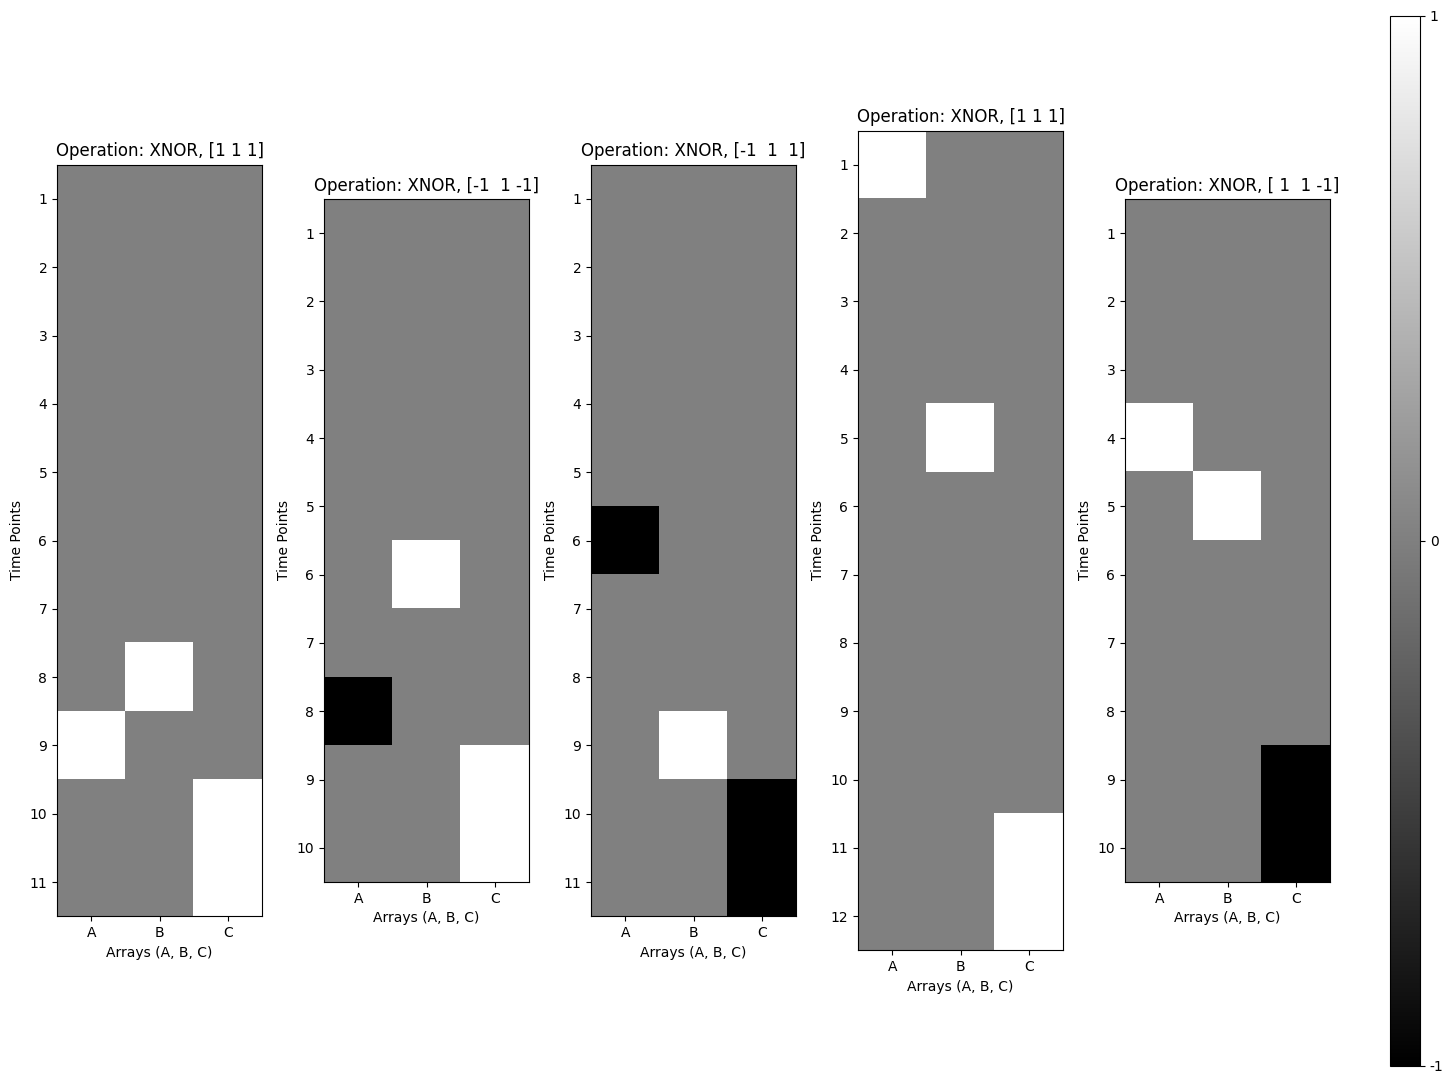

In [500]:
parameters = {
    "min_length": 10,
    "max_length": 15,
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
sequences, labels = generateTrainData(5, parameters)

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax

        operation_title = "XOR" if label[2] == 0 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [501]:
parameters_list = []

min_lengths = [5, 10, 10, 20, 20, 40, 40]
max_lengths = [5, 10, 15, 20, 25, 40, 45]

for min_len, max_len in zip(min_lengths, max_lengths):
    parameters_list.append(
        {
            "min_length": min_len,
            "max_length": max_len,
            "fill": 0,
            "value_1": -1,
            "value_2": 1,
        }
    )

In [502]:
collectorA = dict()
num_samples = 100
for rep in range(1):  # Number of repetitions
    for params in parameters_list:
        params_str = ", ".join([f"{key}: {value}" for key, value in params.items()])

        # Select the model based on 'kind'
        for kind in ["RNN", "NetRNNWithAttention", "NetRNNWithAttentionExpFirst","LSTM", "NetLSTMWithAttention", "GRU", "NetGRUWithAttention"]:
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttention":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "NetRNNWithAttentionExpFirst":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "NetLSTMWithAttention":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "NetGRUWithAttention":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, params)
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind} {rep}"] = A
            params_save_str = " ".join([f"{key}_{value}" for key, value in params.items()])
            torch.save(model, f'models/model_{kind}_{params_save_str}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"Params: {params_str:<40} Time: {epoch_duration:.2f} sec")

RNN, rep: 0, epoch: 1, acc: 0.5033334493637085, Loss 1.038053160905838
RNN, rep: 0, epoch: 2, acc: 0.5899999737739563, Loss 0.9599295181035995
RNN, rep: 0, epoch: 3, acc: 0.6933333873748779, Loss 0.7754093664884567
RNN, rep: 0, epoch: 4, acc: 0.7333332896232605, Loss 0.6606944778561592
RNN, rep: 0, epoch: 5, acc: 0.7033334374427795, Loss 0.6737125924229622
RNN, rep: 0, epoch: 6, acc: 0.6966667175292969, Loss 0.6594766819477081
RNN, rep: 0, epoch: 7, acc: 0.800000011920929, Loss 0.5985074463486671
RNN, rep: 0, epoch: 8, acc: 0.8299997448921204, Loss 0.562473874092102
RNN, rep: 0, epoch: 9, acc: 0.8366665840148926, Loss 0.49017244189977643
RNN, rep: 0, epoch: 10, acc: 0.8999999761581421, Loss 0.3968024541437626
RNN, rep: 0, epoch: 11, acc: 0.9333332777023315, Loss 0.3546666117012501
RNN, rep: 0, epoch: 12, acc: 0.9399998188018799, Loss 0.3218146346509457
RNN, rep: 0, epoch: 13, acc: 0.9800000190734863, Loss 0.25499204561114314
RNN                  Rep: 0   Epoch: 1     Acc: 0.9800 Params

c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


NetRNNWithAttention, rep: 0, epoch: 1, acc: 0.5199999213218689, Loss 1.0257568114995956
NetRNNWithAttention, rep: 0, epoch: 2, acc: 0.6366668939590454, Loss 0.9050984835624695
NetRNNWithAttention, rep: 0, epoch: 3, acc: 0.7733331918716431, Loss 0.721352756023407
NetRNNWithAttention, rep: 0, epoch: 4, acc: 0.699999988079071, Loss 0.660465299487114
NetRNNWithAttention, rep: 0, epoch: 5, acc: 0.8166667222976685, Loss 0.5322286289930344
NetRNNWithAttention, rep: 0, epoch: 6, acc: 0.8433331847190857, Loss 0.39664523750543595
NetRNNWithAttention, rep: 0, epoch: 7, acc: 0.8766664862632751, Loss 0.33793956622481347
NetRNNWithAttention, rep: 0, epoch: 8, acc: 0.9266665577888489, Loss 0.30118595480918886
NetRNNWithAttention, rep: 0, epoch: 9, acc: 0.940000057220459, Loss 0.2603044325113297
NetRNNWithAttention, rep: 0, epoch: 10, acc: 0.9699997901916504, Loss 0.19179649297147988
NetRNNWithAttention, rep: 0, epoch: 11, acc: 0.9700000286102295, Loss 0.19939239766448735
NetRNNWithAttention  Rep: 0  

In [509]:
# Load the model
model = torch.load("./models/model_RNN_min_length_5 max_length_5 fill_0 value_1_-1 value_2_1.model")
model.eval()  # Set the model to evaluation mode

params = {
    'min_length': 5, 
    'max_length': 5, 
    'fill': 0, 
    'value_1': -1, 
    'value_2': 1
}

# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, params)

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = 1.0 * (target_tensor.detach() > 0.0)
        B = 1.0 * (output.detach() > 0.0)
        acc = (1.0 * (A.flatten() == B.flatten())).mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 97.03%
Average Test Loss: 0.2337


In [510]:
# Load the model
model = torch.load("./models/model_NetRNNWithAttention_min_length_5 max_length_5 fill_0 value_1_-1 value_2_1.model")
model.eval()  # Set the model to evaluation mode

params = {
    'min_length': 5, 
    'max_length': 5, 
    'fill': 0, 
    'value_1': -1, 
    'value_2': 1
}

# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, params)

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = (target_tensor > 0.0).float()
        B = (output > 0.0).float()
        acc = (A.flatten() == B.flatten()).float().mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Accuracy: 100.00%
Average Test Loss: 0.1706


In [511]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getOutTaH(model,dataSet):
    O,H=model.step(torch.Tensor(dataSet))
    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())
    H=H.transpose()
    O=O.transpose()
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output,H=getOutTaH(model,dataSet)
    output=output.transpose()[whichTS::dsLength].transpose()
    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

0.0 0.1996837037414183
-0.010227906162740386 0.27401191478877385
-0.03387456693415647 0.3101703481363338
-0.034449928879149105 0.3027195803740068
-0.06044889514663332 0.46799333191829895
-0.047962147985288084 0.532495674081594
-0.08606339109642125 0.5122820279838765
-0.10148531475270861 0.8334788959098267
-0.09330900603545889 0.9268970254188686
-0.09701613240532314 0.9973494794585269


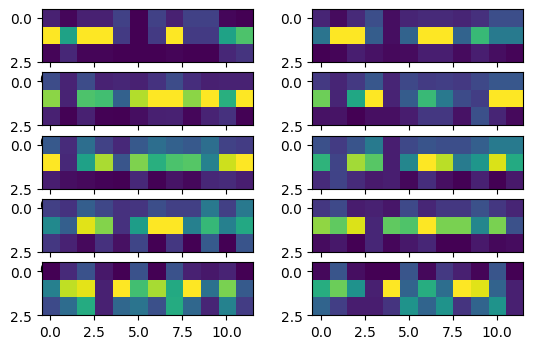

In [541]:
# Load the model
model = torch.load("./Models/model_RNN_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
model.eval()  # Set the model to evaluation mode

params = {
            'min_length': 10, 
            'max_length': 10, 
            'fill': 0, 
            'value_1': -1, 
            'value_2': 1
        }

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, params)  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    imshow(M)
    print(M.min(),M.max())

-0.005005569718913527 0.10451317507833213
-0.016705511471859502 0.24766057434100608
-0.01740010700227934 0.24279715545657687
-0.02124260972961345 0.2714334951014621
-0.013770207998019757 0.4445178750577816
-0.030045908877506022 0.5306334155256032
-0.04749923992525229 0.7551629182619899
-0.04128537548354405 0.8338865832689835
-0.09416811377902246 0.6449099512361229
-0.030574047140864202 0.36213921219646794


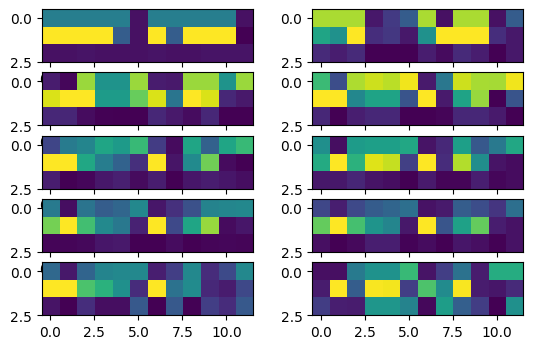

In [542]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttention_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
model.eval()  # Set the model to evaluation mode

params = {
            'min_length': 10, 
            'max_length': 10, 
            'fill': 0, 
            'value_1': -1, 
            'value_2': 1
        }

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, params)  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    imshow(M)
    print(M.min(),M.max())

-2.220446049250313e-16 0.10643036859026012
-0.017728645892067796 0.19635295245046347
-0.021942195578577017 0.23031631998798385
-0.011628797747730513 0.12204351281426451
-0.029110565412027167 0.11361146601742078
-0.01636582997727043 0.11309075508112798
-0.007030435210046093 0.09538638915630848
-0.017584250798138967 0.07104846712201773
-0.03615844123948442 0.06281016307897813
-0.004073121839491822 0.06986978610778394


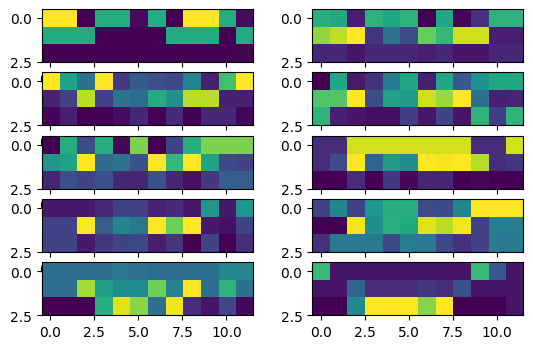

In [543]:
# Load the model
model = torch.load("./Models/model_NetRNNWithAttentionExpFirst_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
model.eval()  # Set the model to evaluation mode

params = {
            'min_length': 10, 
            'max_length': 10, 
            'fill': 0, 
            'value_1': -1, 
            'value_2': 1
        }

# Run the analysis
for i in range(10):
    s, t = generateTrainData(100, params)  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),whichTS=i,dsLength=10)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    imshow(M)
    print(M.min(),M.max())

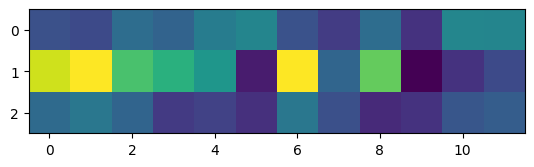

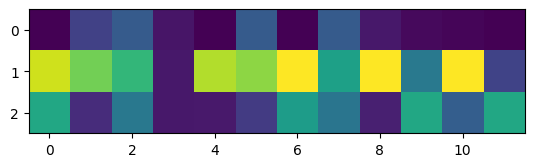

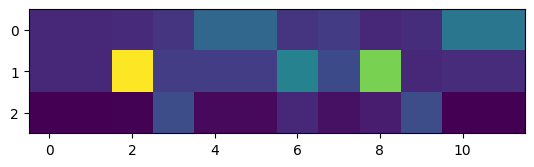

In [540]:

modelRNNWithAttention=torch.load("models/model_RNN_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
modelRNN=torch.load("models/model_NetRNNWithAttention_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
modelRNNWithAttentionExp =torch.load("models/model_NetRNNWithAttentionExpFirst_min_length_10 max_length_10 fill_0 value_1_-1 value_2_1.model")
params = {
            'min_length': 10, 
            'max_length': 10, 
            'fill': 0, 
            'value_1': -1, 
            'value_2': 1
        }
s, t = generateTrainData(100, params)  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),whichTS=8,dsLength=10)
figure()
imshow(removalIntoMatrix(S,12,H))